In [1]:
import numpy as np
import sklearn
import pandas as pd 
import matplotlib.pyplot as plt
import imblearn
import time
import tensorflow as tf
import tensorflow.keras as keras
import os

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# Setup to run on google colab (Ignore this if you are running on local machine)

In [46]:
# Execute only on google colab
# Here I will set up the way to load the dataset from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [47]:
%ls /content/gdrive/MyDrive/Colab-notebooks/2039045/

2039045_face.npz  2039045_nose.csv


In [48]:
# Execute only on google colab 
ROOT_PATH = '/content/gdrive/MyDrive/Colab-notebooks/'
DATA_PATH = os.path.join(ROOT_PATH, '2039045')
%ls $DATA_PATH 

2039045_face.npz  2039045_nose.csv


### Decorator to measure training time

In [2]:
def timeit(method): # Decorator to measure running time
    def timed(*args, **kwargs):
        start = time.time()
        result = method(*args, **kwargs)
        end = time.time()
        return result, round((end - start), 4)
    return timed

# Dataset

In [6]:
DATA_PATH = './2039045'

In [7]:
facial_data = np.load(os.path.join(DATA_PATH, '2039045_face.npz'))
facial_data.files

['X_train', 'y_train', 'X_valid', 'y_valid', 'X_test', 'y_test']

In [8]:
X_train = facial_data['X_train']
y_train = facial_data['y_train']
X_valid = facial_data['X_valid']
y_valid = facial_data['y_valid']
X_test = facial_data['X_test']
y_test = facial_data['y_test']

# Exploratory data analysis tasks

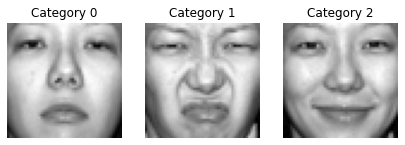

In [9]:
cat_index = dict()
fig_01, ax = plt.subplots(1, 3, figsize = (7, 7))
for i in range(len(np.unique(y_train))):
    cat_index[i] = np.where(y_train == i)[0] # Finding out which indexes belong to each label
    imag = X_train[cat_index[i][0]].reshape((48, 48))
    ax[i].imshow(imag, cmap = 'gray')
    ax[i].set_title(f'Category {i}')
    ax[i].axis('off')
plt.show()

In [10]:
#Combining the target labels
y = np.concatenate((y_train, y_valid, y_test)) 

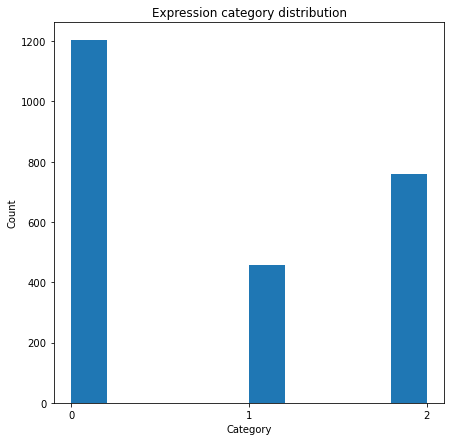

'The data is not balanced'

In [11]:
fig_02, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.hist(y)
ax.set_xticks([0, 1, 2])
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Expression category distribution')
plt.show()
"""The data is not balanced"""

# Classification tasks

## 1.3.1

training time:  0.0014481544494628906
KNN (k = 1) accuracy on test set: 0.7831858407079646


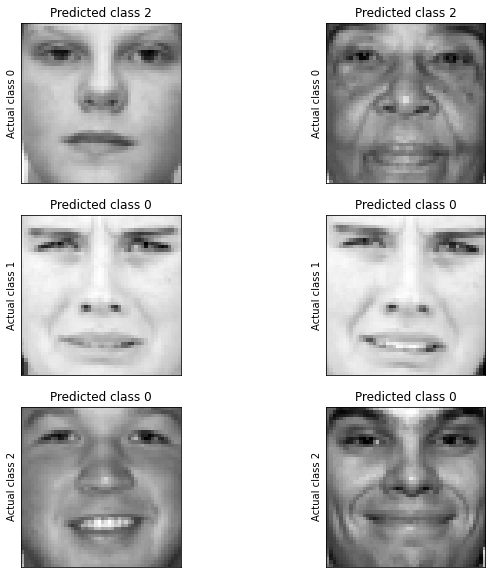

KNN (k = 1) classification report
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       122
           1       0.68      0.42      0.52        40
           2       0.84      0.73      0.78        64

    accuracy                           0.78       226
   macro avg       0.77      0.70      0.72       226
weighted avg       0.78      0.78      0.77       226



In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
import time

# Train KNN with k = 1
start = time.time()
knn_clf = KNeighborsClassifier(n_neighbors = 1, weights = 'uniform')
knn_clf.fit(X_train, y_train)
end = time.time()
time_taken = end - start
print('training time: ', time_taken)

#Calculating accuracy for test set
knn_acc_test = knn_clf.score(X_test, y_test)
print(f'KNN (k = 1) accuracy on test set: {knn_acc_test}')

#Displaying two mis-classified images for each class
y_pred_knn_test = knn_clf.predict(X_test)

mis_classified_index = np.where((y_pred_knn_test == y_test) == False)

fig_03, ax = plt.subplots(3, 2, figsize = (10, 10))
for i in range(3):
    imgs = np.zeros((2, 48, 48))
    count = 0
    for mis_index in mis_classified_index[0]:
        if count == 2:
            break
        if (y_test[mis_index] == i):
            imgs[count] = X_test[mis_index].reshape((48, 48))
            ax[i, count].imshow(imgs[count], cmap = 'gray')
            ax[i, count].set_ylabel(f'Actual class {i}')
            ax[i, count].set_title(f'Predicted class {y_pred_knn_test[mis_index]}')
            ax[i, count].tick_params(axis = 'x', which = 'both', bottom = False, labelbottom = False)
            ax[i, count].tick_params(axis = 'y', which = 'both', left = False, labelleft = False)
            count += 1
            
plt.show()

# Providing other metrics
knn_report_test = classification_report(y_test, y_pred_knn_test)
print('KNN (k = 1) classification report')
print(50 * '-')
print(knn_report_test)

## 1.3.2

In [56]:
# I will find the best number of neighbors
knn_acc_arr = [0]
for i in np.arange(1, 21):
    knn_clf_search = KNeighborsClassifier(n_neighbors = i, weights = 'uniform')
    knn_clf_search.fit(X_train, y_train)
    knn_acc_arr.append(knn_clf_search.score(X_test, y_test))

knn_acc_arr = np.array(knn_acc_arr)
best_k = np.argmax(knn_acc_arr)
print(f'Best number of neighbors: {best_k}')

Best number of neighbors: 3


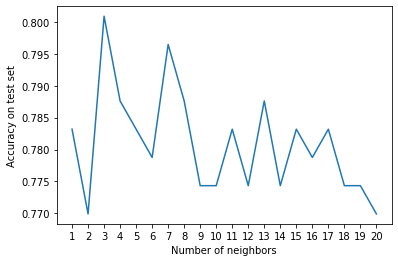

In [57]:
fig_04, ax = plt.subplots()
ax.plot(knn_acc_arr[1:])
ax.set_xticks(np.arange(0, 20))
ax.set_xticklabels(list(np.arange(1, 21)))
ax.set_xlabel('Number of neighbors')
ax.set_ylabel('Accuracy on test set')
plt.show()

## 1.3.3

In [58]:
X_train.shape, y.shape

((1946, 2304), (2417,))

In [59]:
print(np.bincount(y_train), np.bincount(y_valid), np.bincount(y_test))

[963 372 611] [117  45  83] [122  40  64]


### Balancing the dataset

In [60]:
from imblearn.over_sampling import RandomOverSampler

over_sample = RandomOverSampler(sampling_strategy = 'not majority')

In [61]:
X_train_oversample, y_train_oversample = over_sample.fit_resample(X_train, y_train)
print(X_train_oversample.shape, np.bincount(y_train_oversample))

(2889, 2304) [963 963 963]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


## Training and evaluating models

### Class and function to find the best hyperparameters

In [62]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
class OptimizingParamaters(BaseEstimator, TransformerMixin): # A class which has a purpose of finding the best parameters
    def __init__(self, model, params_dict, data_transformer = None):
        self.data_transformer = data_transformer
        self.params_dict_ = params_dict
        self.model = model
        self.best_params_ = {}
        self.best_acc_ = float('-inf')
        self.best_time_ = 0
        self.best_metrics_ = {}
        self.best_yPred_ = []
    @timeit
    def model_training(self, params, X, y = None): #Training the model
        self.model.set_params(**params)
        self.model.fit(X, y)
    def fit(self, X, y = None):
        if (self.data_transformer is not None):
            X_valid_transformed = self.data_transformer.transform(X_valid)
        else:
            X_valid_transformed = X_valid
        for combination in list(ParameterGrid(self.params_dict_)): # Running through every combination of parameters
            _, computation_time = self.model_training(combination, X, y)
            y_pred = self.predict(X_valid_transformed)
            acc = accuracy_score(y_valid, y_pred)
            if acc > self.best_acc_:
                self.best_acc_ = acc
                self.best_params_ = combination
                self.best_time_ = computation_time
                self.best_yPred_ = list(y_pred)
        self.best_metrics_ = classification_report(y_valid, self.best_yPred_, output_dict = True)
    def transform(self, X):
        pass
    def predict(self, X):
        return self.model.predict(X)
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    def score(self, X, y):
        return self.model.score(X, y)
    

In [63]:
def full_pipeline(X_train, y_train, X_test, y_test, model, param_grid, data_transformer = None):
    if data_transformer is not None:
        #try:
            #X_train_transformed = data_transformer.fit_transform(X_train)
            #X_test_transformed = data_transformer.transform(X_test)
        #except ValueError:
        X_train_transformed = data_transformer.fit_transform(X_train, y_train)
        X_test_transformed = data_transformer.transform(X_test)
    else:
        X_train_transformed = X_train
        X_test_transformed = X_test
    # Finding the best hyperparameters
    hyperpara_optimizer = OptimizingParamaters(model, param_grid, data_transformer)
    hyperpara_optimizer.fit(X_train_transformed, y_train)
    best_params = hyperpara_optimizer.best_params_
    best_time = hyperpara_optimizer.best_time_
    
    # Metrics tested on test set
    best_model = model.set_params(**hyperpara_optimizer.best_params_)
    best_model.fit(X_train_transformed, y_train)
    y_pred = best_model.predict(X_test_transformed)
    test_metrics = classification_report(y_test, y_pred, output_dict = True)
    
    # Extract accuracy, macro-avg precison, recall, and F1 score. I use [:-1] because I don't want to extract support
    important_metrics = [test_metrics['accuracy'], *test_metrics['macro avg'].values()][:-1] 
    important_metrics.insert(0, best_time) 
    
    # [time, accuracy, macro-avg precision, recall, F1] and a best hyperparameters dict
    return important_metrics, best_params 
    

### Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from itertools import chain
from sklearn.decomposition import PCA

log_clf = LogisticRegression(random_state = 42, max_iter = 1000)
log_grid = {'C': list(chain.from_iterable((0.001 * (10 ** i), 0.005 * (10 ** i)) for i in range(6)))}
pca = PCA(n_components = 0.95) # I want to preserve 95% of the training set variance

log_metrics, log_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = log_clf,
                                         param_grid = log_grid,
                                         data_transformer = pca)


In [66]:
print(log_metrics)
print(40 * '-')
print(log_params)

[1.0263, 0.8761061946902655, 0.8540272844704525, 0.8707308743169399, 0.8608392679082634]
----------------------------------------
{'C': 0.5}


### Decision Trees with Gradient Boosting 

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier


gb_clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3, learning_rate = 0.1)
gb_grid = {'max_depth': list(range(1, 6)), 'max_features' : [None, 'sqrt', 'log2', 0.3]}
select_rndForests = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=42), 
                                    threshold = 'median') # Using random forests to choose the best features
gb_metrics, gb_params = full_pipeline(X_train = X_train_oversample, 
                                     y_train = y_train_oversample,
                                     X_test = X_test,
                                     y_test = y_test,
                                     model = gb_clf,
                                     param_grid = gb_grid,
                                     data_transformer = select_rndForests)

In [68]:
print(gb_metrics)
print(40 * '-')
print(gb_params)

[5.7657, 0.8805309734513275, 0.8598136947431302, 0.8392076502732241, 0.8485769980506822]
----------------------------------------
{'max_depth': 4, 'max_features': 'sqrt'}


### SVM

In [69]:
from sklearn.svm import SVC
from itertools import chain

svc_clf = SVC(random_state = 42)
svc_grid = {'C': [0.001 * (10 ** i) for i in range(6)], 
           'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]}
pca = PCA(n_components = 0.95) # I want to preserve 95% of the training set variance

svc_metrics, svc_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = svc_clf,
                                         param_grid = svc_grid,
                                         data_transformer = pca)

In [71]:
print(svc_metrics)
print(40 * '-')
print(svc_params)

[0.3717, 0.911504424778761, 0.8996499853672812, 0.8769637978142076, 0.8863141968806895]
----------------------------------------
{'C': 10.0, 'gamma': 'scale'}


### Voting classifier

In [72]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(estimators = [('lr', log_clf), ('gb', gb_clf), ('svc', svc_clf)], 
                              voting = 'hard',
                             n_jobs = -1)
voting_grid = {}
pca = PCA(n_components = 0.95)

voting_metrics, voting_params = full_pipeline(X_train = X_train_oversample, 
                                         y_train = y_train_oversample,
                                         X_test = X_test,
                                         y_test = y_test,
                                         model = voting_clf,
                                         param_grid = voting_grid,
                                         data_transformer = None)

In [74]:
print(voting_metrics)
print(40 * '-')
print(voting_params)

[34.4884, 0.9070796460176991, 0.9199125725843283, 0.8661543715846994, 0.8868675196278836]
----------------------------------------
{}


### Neural network

In [37]:
# Reshape each image to 48 * 48
X_train_reshaped = X_train_oversample.reshape(-1, 48, 48) / 255
X_valid_reshaped = X_valid.reshape(-1, 48, 48) / 255
X_test_reshaped = X_test.reshape(-1, 48, 48) / 255
print(X_train_reshaped.shape)

(2889, 48, 48)


In [38]:
X_train_reshaped = X_train_reshaped[..., np.newaxis] # Reshaped to 2889*48*48*1
X_valid_reshaped = X_valid_reshaped[..., np.newaxis]
X_test_reshaped = X_test_reshaped[..., np.newaxis]

In [33]:
def build_cnn_model(learning_rate = 1e-2):
    # Building a CNN
    model = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation = 'relu', padding = 'same', input_shape = [48, 48, 1]),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same'),
    keras.layers.MaxPool2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = 'softmax')
])
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(loss = 'sparse_categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics = ['accuracy'] 
                 )
    return model

In [43]:
from sklearn.metrics import classification_report
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
cnn_clf = keras.wrappers.scikit_learn.KerasClassifier(build_cnn_model)
cnn_grid = {'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]}


def cnn_pipeline(X_train, y_train, X_valid, y_valid, X_test, y_test, model, param_grid):
  best_acc = float('-inf')
  best_time = 0
  best_yPred = []
  best_params = {}
  best_metrics = {}
  for combination in list(ParameterGrid(param_grid)): # Running through every combination of parameters
              model.set_params(**combination)
              start = time.time()
              model.fit(X_train, y_train, epochs = 100, 
                        validation_data = (X_valid, y_valid),
                        callbacks = [keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)],
                        )
              end = time.time()
              computation_time = np.round(end - start, 4)
              y_pred = model.predict(X_valid)
              acc = accuracy_score(y_valid, y_pred)
              if acc > best_acc: #Saving parameters for the current model performs well on the validation data set
                  best_acc = acc
                  best_params = combination
                  best_time = computation_time
  # Metrics tested on test set
  best_model = model.set_params(**best_params)
  model.fit(X_train, y_train, epochs = 100, 
                      validation_data = (X_valid, y_valid),
                      callbacks = [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)],
                      )
  y_pred_test = best_model.predict(X_test)
  test_metrics = classification_report(y_test, y_pred_test, output_dict = True)
  
  # Extract accuracy, macro-avg precison, recall, and F1 score. I use [:-1] because I don't want to extract support
  important_metrics = [test_metrics['accuracy'], *test_metrics['macro avg'].values()][:-1] 
  important_metrics.insert(0, best_time) 
  
  # [time, accuracy, macro-avg precision, recall, F1] and a best hyperparameters dict
  return important_metrics, best_params 

cnn_metrics, cnn_params = cnn_pipeline(X_train = X_train_reshaped,
                                       y_train = y_train_oversample,
                                       X_valid = X_valid_reshaped,
                                       y_valid = y_valid,
                                       X_test = X_test_reshaped,
                                       y_test = y_test,
                                       model = cnn_clf,
                                       param_grid = cnn_grid)

Epoch 1/100
91/91 [==============================] - 2s 14ms/step - loss: 1.0971 - accuracy: 0.3461 - val_loss: 1.0950 - val_accuracy: 0.3429
Epoch 2/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0493 - accuracy: 0.4528 - val_loss: 0.8463 - val_accuracy: 0.6122
Epoch 3/100
91/91 [==============================] - 1s 11ms/step - loss: 0.7404 - accuracy: 0.6836 - val_loss: 0.5172 - val_accuracy: 0.8204
Epoch 4/100
91/91 [==============================] - 1s 11ms/step - loss: 0.5825 - accuracy: 0.7726 - val_loss: 0.3803 - val_accuracy: 0.8653
Epoch 5/100
91/91 [==============================] - 1s 11ms/step - loss: 0.4839 - accuracy: 0.8082 - val_loss: 0.3202 - val_accuracy: 0.8898
Epoch 6/100
91/91 [==============================] - 1s 11ms/step - loss: 0.3899 - accuracy: 0.8657 - val_loss: 0.3040 - val_accuracy: 0.8898
Epoch 7/100
91/91 [==============================] - 1s 11ms/step - loss: 0.3205 - accuracy: 0.8865 - val_loss: 0.2472 - val_accuracy: 0.9102
Epoch 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Epoch 1/100
91/91 [==============================] - 2s 13ms/step - loss: 1.1007 - accuracy: 0.3278 - val_loss: 1.0993 - val_accuracy: 0.1837
Epoch 2/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0989 - accuracy: 0.3209 - val_loss: 1.0986 - val_accuracy: 0.4776
Epoch 3/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0988 - accuracy: 0.3392 - val_loss: 1.0955 - val_accuracy: 0.4776
Epoch 4/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0990 - accuracy: 0.3358 - val_loss: 1.0975 - val_accuracy: 0.4776
Epoch 5/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0990 - accuracy: 0.3157 - val_loss: 1.0988 - val_accuracy: 0.1837
Epoch 6/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0988 - accuracy: 0.3306 - val_loss: 1.0992 - val_accuracy: 0.3388
Epoch 7/100
91/91 [==============================] - 1s 11ms/step - loss: 1.0989 - accuracy: 0.3219 - val_loss: 1.0988 - val_accuracy: 0.3388
Epoch 

In [44]:
print(cnn_metrics)
print(40 * '-')
print(cnn_params)

[27.7706, 0.9778761061946902, 0.968204365079365, 0.9782616120218579, 0.9730218621917625]
----------------------------------------
{'learning_rate': 0.0001}


# Saving figures and tables

In [75]:
IMAGES_PATH = os.path.join(ROOT_PATH, 'facial_images')
fig_01.savefig(os.path.join(IMAGES_PATH, 'fig_01.png'))
fig_02.savefig(os.path.join(IMAGES_PATH, 'fig_02.png'))
fig_03.savefig(os.path.join(IMAGES_PATH, 'fig_03.png'))
fig_04.savefig(os.path.join(IMAGES_PATH, 'fig_04.png'))

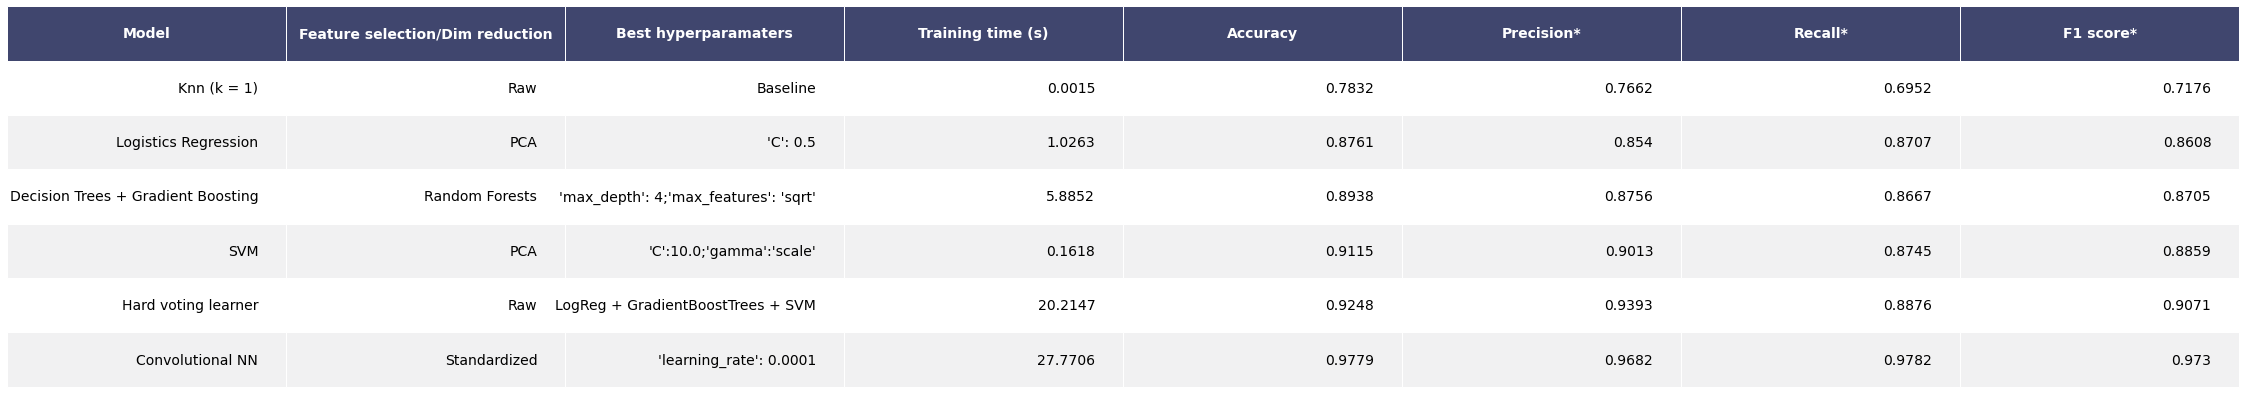

In [87]:
import six

df = pd.read_csv(os.path.join(ROOT_PATH, 'facial-result.csv'))

def render_mpl_table(data, col_width=2.0, row_height=1.0, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return fig, ax

fig_05, ax = render_mpl_table(df, header_columns=0, col_width=5.0)

In [88]:
fig_05.savefig(os.path.join(IMAGES_PATH, 'fig_05.png'))

In [83]:
df

,Model,Feature selection/Dim reduction,Best hyperparamaters,Training time (s),Accuracy,Precision*,Recall*,F1 score*
0,Knn (k = 1),Raw,Baseline,0.0015,0.7832,0.7662,0.6952,0.7176
1,Logistics Regression,PCA,'C': 0.5,1.0263,0.8761,0.8540,0.8707,0.8608
2,Decision Trees + Gradient Boosting,Random Forests,'max_depth': 4;'max_features': 'sqrt',5.8852,0.8938,0.8756,0.8667,0.8705
3,SVM,PCA,'C': 10.0;'gamma': 'scale',0.1618,0.9115,0.9013,0.8745,0.8859
4,Hard voting learner,Raw,LogReg + GradientBoostTrees + SVM,20.2147,0.9248,0.9393,0.8876,0.9071
5,Convolutional NN,Standardized,'learning_rate': 0.0001,27.7706,0.9779,0.9682,0.9782,0.9730
